In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(20,10)})
sns.set()

## Inspired by time series momentum, as described in
`Moskowitz, Tobias, Yao Hua Ooi, and Lasse Heje Pedersen (2012): "Time Series Momentum." Journal of Financial Economics, Vol. 104, 228-250`
https://www.sciencedirect.com/science/article/pii/S0304405X11002613



In [2]:
class TradeBot(): 
    '''
    Assumptions for easier work:
        1* infinite usd available
        2* bot is always able to execute a trade for self.trade_units at the last seen price
    '''
    def __init__(self, momentum, df_btc, df_eth, tick_limit=500):
        self.tick_limit = tick_limit
        self.ticks = {'btc': 0, 'eth': 0}
        self.momentum = momentum
        self.resampling_interval = '5s'
        self.trade_units = 100
        self.positions = {'btc': 0, 'eth': 0}
        self.assets = {'btc': 0,
                       'eth': 0,
                       'usd': 0
                       }
        self.momentum_high = None
        
        self.df_btc = df_btc
        self.df_btc.index = pd.DatetimeIndex(self.df_btc['date'])
        
        self.df_eth = df_eth
        self.df_eth.index = pd.DatetimeIndex(self.df_eth['date'])
        self.last_prices = {'btc': self.df_btc.iloc[-1].price,
                            'eth': self.df_eth.iloc[-1].price}
        
    def create_order(self, side, currency, amount):
        '''
        Mocks creating an order at the exchange with assumption 2* 
        Keeps track of currently available assets
        '''
        price = self.last_prices[currency]
        print('Creating %s - %s order for %f @%f' % (currency, side, amount, price))
        if side == 'short':
            self.assets[currency] = self.assets[currency] - amount
            self.assets['usd'] = self.assets['usd'] + (amount * price)
        elif side == 'long':
            self.assets[currency] = self.assets[currency] + amount
            self.assets['usd'] = self.assets['usd'] - (amount * price)
        else:
            raise Exception('Invalid order side', side)
    
    def update_state(self, data):
        if 'btc' in data['symbol']:
            self.df_btc = self.df_btc.append(data)
            self.df_btc.index = pd.DatetimeIndex(self.df_btc['date'])
            self.last_prices['btc'] = data['price']
        if 'eth' in data['symbol']:
            self.df_eth = self.df_eth.append(data)
            self.df_eth.index = pd.DatetimeIndex(self.df_eth['date'])
            self.last_prices['eth'] = data['price']
        
    def calculate_returns(self):
        '''
        Resamples the data set to a new interval.
        Calculates log returnes
        Calculates and returnes rolling momentum mean for each currency
        '''
        dfr_eth = self.df_eth.resample(self.resampling_interval).last()
        dfr_eth = dfr_eth[~dfr_eth.id.isnull()] # all None's row occuring
        dfr_eth['returns'] = np.log(dfr_eth['price'] / dfr_eth['price'].shift(1))
        eth_momentum_returnes = dfr_eth['returns'].rolling(self.momentum).mean().iloc[-1]
        
        dfr_btc = self.df_btc.resample('5s').last()
        dfr_btc = dfr_btc[~dfr_btc.id.isnull()] # all None's row occuring
        dfr_btc['returns'] = np.log(dfr_btc['price'] / dfr_btc['price'].shift(1))
        btc_momentum_returnes = dfr_btc['returns'].rolling(self.momentum).mean().iloc[-1]

        return eth_momentum_returnes, btc_momentum_returnes
    
    def manage_order(self, currency, current_position, wanted_position):
        '''
        Decides which order to execute based on current and desired position
        '''
        if wanted_position == 1:
            # go long
            if current_position == 0:
                self.create_order('long', currency, self.trade_units / 2.)
            elif current_position == -1:
                self.create_order('long', currency, self.trade_units)
            self.positions[currency] = 1
        elif wanted_position == -1:
            # go short
            if current_position == 0:
                self.create_order('short', currency, self.trade_units / 2.)
            elif current_position == 1:
                self.create_order('short', currency, self.trade_units)
            self.positions[currency] = -1
        
    def on_tick(self, data):
        '''
        Main handler, gets triggered on each new data points
        '''
        pair = data['symbol']
        currency = pair[:3]
        self.ticks[currency] += 1

        self.update_state(data)
        eth_mr, btc_mr = self.calculate_returns()
        
        # Should decide on strategy:
        #  A => Long BTC, Short ETH
        #  B => Long ETH, Short BTC
        # Instead assume pair indepedancy and decide for each (under assumption 1*)
        self.manage_order('eth', self.positions['eth'], np.sign(eth_mr))
        self.manage_order('btc', self.positions['btc'], np.sign(btc_mr))

        # close out the position at the end of trading window
        if sum(self.ticks.values()) == self.tick_limit:
            for currency, position in self.positions.items():
                if position == 1:
                    self.create_order('short', currency, self.trade_units / 2.)
                elif position == -1:
                    self.create_order('long', currency, self.trade_units / 2.)
            print('Trading window ended!')

# Training

In [3]:
# Load 'train' data, this is done so that the bot has already some
# log returnes calculated at the start of his trading window
# Basically bot just observes the market for the duration of train data
# and starts trading on test data
train_btc_df = pd.read_csv('data/Raw/Bitfinex/BTCUSD/2018_01/Bitfinex_BTCUSD_trades_2018_01_02.csv.gz')
train_eth_df = pd.read_csv('data/Raw/Bitfinex/ETHUSD/2018_01/Bitfinex_ETHUSD_trades_2018_01_02.csv.gz')

train_df = train_btc_df.append(train_eth_df)
train_btc_df['date'] = pd.to_datetime(train_btc_df['date'],unit='ms')
train_eth_df['date'] = pd.to_datetime(train_eth_df['date'],unit='ms')
train_df.sort_values('date')
train_df.symbol.value_counts()

btcusd    197829
ethusd    115643
Name: symbol, dtype: int64

## Finding optimal momentum

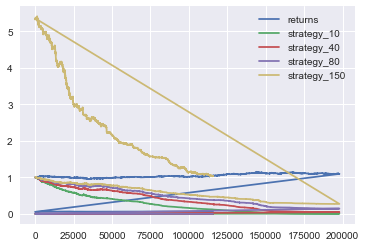

In [4]:
train_df['returns'] = np.log(train_df['price'] / train_df['price'].shift(1))

momentum_cols = []

for momentum in [10, 40, 80, 150]:
    m_col = 'position_%s' % momentum
    train_df[m_col] = np.sign(train_df['returns'].rolling(momentum).mean())
    momentum_cols.append(m_col)
    
strats = ['returns']

for m_col in momentum_cols:
    strat = 'strategy_%s' % m_col.split('_')[1]
    train_df[strat] = train_df[m_col].shift(1) * train_df['returns']
    strats.append(strat)

train_df[strats].dropna().cumsum().apply(np.exp).plot()

# Sanity check unit tests

In [5]:
unit_bot = TradeBot(1, train_btc_df, train_eth_df)

start_btc = unit_bot.assets['btc']
start_usd = unit_bot.assets['usd']
btc_price = unit_bot.last_prices['btc'] 
trade_units = unit_bot.trade_units
unit_bot.create_order('long', 'btc', trade_units)

print(unit_bot.assets)
assert unit_bot.assets['usd'] == -1*trade_units * btc_price+start_usd

unit_bot.create_order('short', 'btc', trade_units)
end_btc = unit_bot.assets['btc']

assert start_btc == end_btc, 'Assets calculation error'
print('Bot assets in original state')
unit_bot.assets

Creating btc - long order for 100.000000 @14722.000000
{'btc': 100, 'eth': 0, 'usd': -1472200.0}
Creating btc - short order for 100.000000 @14722.000000
Bot assets in original state


{'btc': 0, 'eth': 0, 'usd': 0.0}

In [6]:
unit_bot = TradeBot(15, train_btc_df, train_eth_df, 100)

unit_bot.create_order('long', 'btc', trade_units)
after_long_btc = unit_bot.assets['btc']
after_long_usd = unit_bot.assets['usd']

unit_bot.create_order('short', 'btc', trade_units / 2.)
after_short_btc = unit_bot.assets['btc']
after_short_usd = unit_bot.assets['usd']

assert after_long_btc / 2. == after_short_btc, 'Assets calculation error'
assert after_long_usd / 2. == after_short_usd , 'Assets calculation error'
unit_bot.assets

Creating btc - long order for 100.000000 @14722.000000
Creating btc - short order for 50.000000 @14722.000000


{'btc': 50.0, 'eth': 0, 'usd': -736100.0}

# Testing

In [7]:
# Test data
test_btc_df = pd.read_csv('data/Raw/Bitfinex/BTCUSD/2018_01/Bitfinex_BTCUSD_trades_2018_01_03.csv.gz')
test_eth_df = pd.read_csv('data/Raw/Bitfinex/ETHUSD/2018_01/Bitfinex_ETHUSD_trades_2018_01_03.csv.gz')
test_df = test_btc_df.append(test_eth_df)
test_df['date'] = pd.to_datetime(test_df['date'],unit='ms')
test_df.sort_values('date')
test_df.symbol.value_counts()

btcusd    163143
ethusd     94195
Name: symbol, dtype: int64

In [8]:
best_momentum = 10
tick_limit = 100
bot = TradeBot(best_momentum, train_btc_df, train_eth_df, tick_limit)

In [9]:
for idx, tick in test_df[:bot.tick_limit+1].iterrows():
        bot.on_tick(tick)
bot.assets

Creating eth - short order for 50.000000 @858.780000
Creating btc - long order for 50.000000 @14717.000000
Creating btc - short order for 100.000000 @14713.000000
Creating btc - long order for 100.000000 @14717.000000
Creating btc - short order for 50.000000 @14728.000000
Creating eth - long order for 50.000000 @858.780000
Trading window ended!


{'btc': 0.0, 'eth': 0.0, 'usd': 150.0}